# Image area selection tool for isolating flakes for training

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets
import time
import sys


def display_image_with_grid(image, title="Image with Coordinate Grid"):
    """Display image with coordinate grid and markers."""
    # Clear any previous output
    clear_output(wait=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.imshow(image)
    ax.grid(True, alpha=0.3)
    ax.set_title(title)
    
    # Add coordinate markers every 100 pixels
    width, height = image.size
    for x in range(0, width, 100):
        ax.axvline(x, color='red', alpha=0.5, linewidth=0.8)
        ax.text(x, 50, str(x), color='red', fontsize=10, rotation=90)
    
    for y in range(0, height, 100):
        ax.axhline(y, color='red', alpha=0.5, linewidth=0.8)
        ax.text(50, y, str(y), color='red', fontsize=10)
    
    plt.tight_layout()
    
    # Force the plot to display and wait
    plt.show()
    
    # Add a small delay to ensure the plot renders before continuing
    time.sleep(0.5)
    
    # Force flush of stdout to ensure everything is displayed
    sys.stdout.flush()


def select_crop_coordinates(image):
    """Select crop coordinates from the original image."""
    width, height = image.size
    
    display_image_with_grid(image, "Original Image - Select Crop Region")
    
    print(f"\nImage dimensions: {width} × {height} pixels")
    print("Use the coordinate grid to determine your crop region:")
    print("\nCROP REGION (or press Enter to skip):")
    
    # Additional flush to ensure the text appears
    sys.stdout.flush()
    
    try:
        top = input("Top edge (y): ").strip()
        if top:
            bottom = input("Bottom edge (y): ")
            left = input("Left edge (x): ")
            right = input("Right edge (x): ")
            crop_coords = [int(top), int(bottom), int(left), int(right)]
            print(f"Crop: {crop_coords}")
            return crop_coords
        else:
            print("Skipping crop region")
            return None
    except:
        print("Invalid input, skipping crop")
        return None


def select_masking_coordinates(cropped_image):
    """Select masking coordinates relative to the cropped image."""
    width, height = cropped_image.size
    
    display_image_with_grid(cropped_image, "Cropped Image - Select Masking Regions")
    
    print(f"\nCropped image dimensions: {width} × {height} pixels")
    print("Coordinates are now relative to the cropped image (0,0 at top-left)")
    
    # Force flush before input
    sys.stdout.flush()
    
    # Ask for number of masking regions
    try:
        num_masks = input("\nHow many masking regions do you want to create? (or 0 to skip): ").strip()
        num_masks = int(num_masks)
        if num_masks <= 0:
            print("Skipping masking regions")
            return None
    except:
        print("Invalid input, skipping masking")
        return None
    
    print(f"\nCreating {num_masks} masking region(s):")
    
    masking_regions = []
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
    
    for mask_num in range(1, num_masks + 1):
        print(f"\nMask {mask_num} ({colors[(mask_num-1) % len(colors)]}):")
        sys.stdout.flush()  # Ensure prompt appears
        try:
            top = int(input("Top edge (y): "))
            bottom = int(input("Bottom edge (y): "))
            left = int(input("Left edge (x): "))
            right = int(input("Right edge (x): "))
            
            mask = [top, bottom, left, right]
            masking_regions.append(mask)
            print(f"Mask {mask_num}: {mask}")
        except:
            print(f"Invalid input for mask {mask_num}, skipping")
            continue
    
    return masking_regions if masking_regions else None


def display_cropped_with_masks(cropped_image, masking_regions):
    """Display the cropped image with colored mask regions highlighted."""
    if not masking_regions:
        return
    
    # Clear output before showing final result
    clear_output(wait=True)
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.imshow(cropped_image)
    ax.set_title("Cropped Image with Masking Regions Highlighted")
    
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
    
    for i, mask in enumerate(masking_regions):
        top, bottom, left, right = mask
        color = colors[i % len(colors)]
        
        # Create rectangle patch
        rect = patches.Rectangle((left, top), right - left, bottom - top,
                               linewidth=3, edgecolor=color, facecolor=color, alpha=0.3)
        ax.add_patch(rect)
        
        # Add label
        ax.text(left + 10, top + 20, f'Mask {i+1}', 
                color=color, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Small delay to ensure the plot renders
    time.sleep(0.5)
    sys.stdout.flush()
    
    print(f"\nDisplayed {len(masking_regions)} masking region(s) with colored highlights")


def generate_json_config(img_file, flake_name, crop_coords, masking_regions):
    """Generate and print JSON configuration format."""
    
    config = {
        'img_file': img_file,
        'flake_name': flake_name,
        'crop': crop_coords,
        'masking': masking_regions
    }
    
    print("\n" + "="*50)
    print("JSON CONFIGURATION:")
    print("="*50)
    
    # Format manually for better control
    print("{")
    print(f"    \"img_file\": \"{img_file}\",")
    print(f"    \"flake_name\": \"{flake_name}\",")
    
    if crop_coords:
        crop_str = str(crop_coords).replace(' ', '')
        print(f"    \"crop\": {crop_str},")
    else:
        print(f"    \"crop\": null,")
    
    if masking_regions:
        masking_str = str(masking_regions).replace(' ', '')
        print(f"    \"masking\": {masking_str}")
    else:
        print(f"    \"masking\": null")
    
    print("},")
    
    return config


def coordinate_selection_workflow(img_file):
    """Complete workflow for selecting crop and masking coordinates."""
    # Load original image
    original_image = Image.open(img_file)
    
    # Step 1: Select crop coordinates
    crop_coords = select_crop_coordinates(original_image)
    
    # Step 2: If cropping was selected, crop the image and show it
    if crop_coords:
        top, bottom, left, right = crop_coords
        cropped_image = original_image.crop((left, top, right, bottom))
        print(f"\nImage cropped to region: {crop_coords}")
    else:
        cropped_image = original_image
        print(f"\nUsing full original image")
    
    # Step 3: Select masking coordinates on the cropped image
    masking_regions = select_masking_coordinates(cropped_image)
    
    # Step 4: Display cropped image with mask highlights
    if masking_regions:
        display_cropped_with_masks(cropped_image, masking_regions)
    
    # Step 5: Get flake name for JSON config
    print("\nEnter flake name for JSON config:")
    sys.stdout.flush()
    flake_name = input("Flake name: ").strip()
    if not flake_name:
        flake_name = "Unknown"
    
    # Summary
    print("\n" + "="*50)
    print("SELECTION SUMMARY:")
    print("="*50)
    if crop_coords:
        print(f"Crop coordinates (original image): {crop_coords}")
    else:
        print("No cropping applied")
    
    if masking_regions:
        print(f"Colors used: {', '.join(['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta'][:len(masking_regions)])}")
        print(f"Masking regions (cropped image coordinates): {masking_regions}")
    else:
        print("No masking regions selected")
    
    # Step 6: Generate JSON configuration
    config = generate_json_config(img_file, flake_name, crop_coords, masking_regions)
    
    return crop_coords, masking_regions, config

# Enter image path below then follow prompts 

Copy final JSON configuration into training notebook

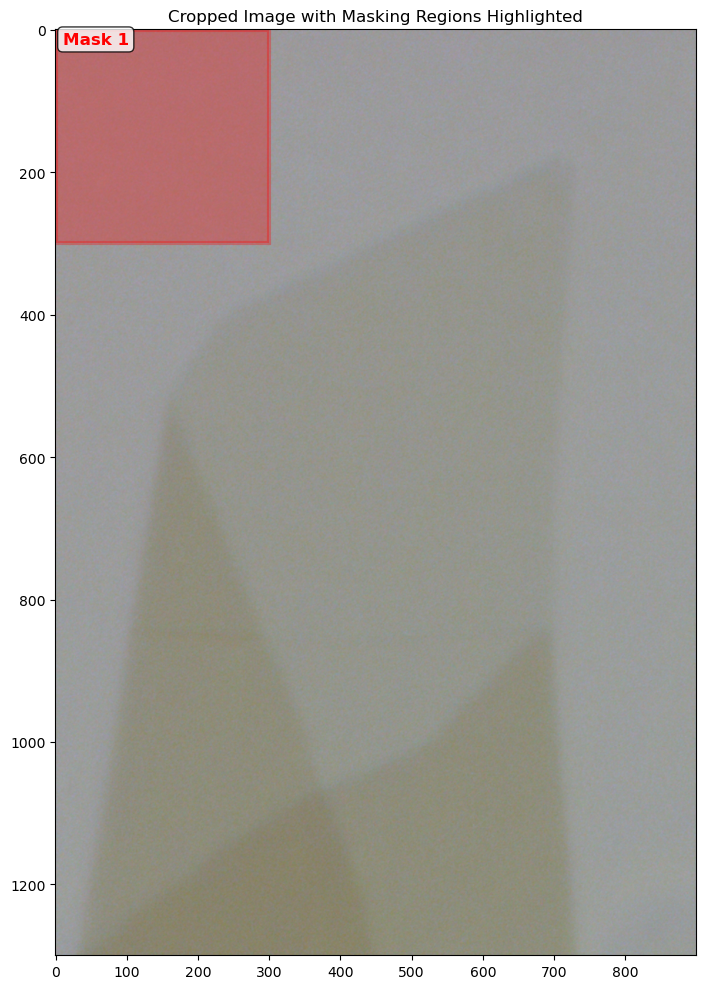


Displayed 1 masking region(s) with colored highlights

Enter flake name for JSON config:

SELECTION SUMMARY:
Crop coordinates (original image): [0, 1300, 2100, 3000]
Colors used: red
Masking regions (cropped image coordinates): [[0, 300, 0, 300]]

JSON CONFIGURATION:
{
    "img_file": "image_data/example_testing/Fig_4i.jpg",
    "flake_name": "mos2_pdms",
    "crop": [0,1300,2100,3000],
    "masking": [[0,300,0,300]]
},


In [8]:
## Enter your image file path here
image_file_path = "image_data/example_testing/Fig_4i.jpg"

## This runs the coordinate selector
crop_coords, masking_regions, config = coordinate_selection_workflow(image_file_path)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json
from collections import defaultdict



def visualize_processing_steps(entry, original_image):
    """
    Show the step-by-step processing for a single entry: Original -> Cropped -> Masked
    """
    flake_name = entry['flake_name']
    crop_coords = entry['crop']
    masking_regions = entry['masking']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Processing Steps for {flake_name}", fontsize=16, fontweight='bold')
    
    # Step 1: Original Image
    axes[0].imshow(original_image)
    axes[0].set_title("1. Original Image")
    axes[0].grid(True, alpha=0.3)
    
    # Highlight crop region on original if specified
    if crop_coords:
        top, bottom, left, right = crop_coords
        crop_rect = patches.Rectangle(
            (left, top), right - left, bottom - top,
            linewidth=3, edgecolor='lime', facecolor='none'
        )
        axes[0].add_patch(crop_rect)
        axes[0].text(left + 10, top + 20, 'Crop Region', 
                    color='lime', fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    # Step 2: Cropped Image
    cropped_image = np.array(original_image)
    if crop_coords:
        top, bottom, left, right = crop_coords
        cropped_image = cropped_image[top:bottom, left:right]
    
    axes[1].imshow(cropped_image)
    axes[1].set_title("2. Cropped Image")
    axes[1].grid(True, alpha=0.3)
    
    # Step 3: Cropped + Masked Image
    axes[2].imshow(cropped_image)
    axes[2].set_title("3. Cropped + Masked Areas")
    axes[2].grid(True, alpha=0.3)
    
    # Add masking visualization
    if masking_regions:
        colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
        
        for mask_idx, mask in enumerate(masking_regions):
            mask_top, mask_bottom, mask_left, mask_right = mask
            color = colors[mask_idx % len(colors)]
            
            # Create rectangle patch for mask region
            rect = patches.Rectangle(
                (mask_left, mask_top), 
                mask_right - mask_left, 
                mask_bottom - mask_top,
                linewidth=3, 
                edgecolor=color, 
                facecolor=color, 
                alpha=0.5
            )
            axes[2].add_patch(rect)
            
            # Add mask label
            axes[2].text(
                mask_left + 10, mask_top + 20, 
                f'Mask {mask_idx+1}', 
                color='white', 
                fontsize=10, 
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=color, alpha=0.8)
            )
    
    for ax in axes:
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
    
    plt.tight_layout()
    plt.show()


def visualize_detailed_json_config(json_config):
    """
    Detailed visualization showing step-by-step processing for each entry.
    """
    print(f"{'='*80}")
    print(f"DETAILED JSON CONFIGURATION VISUALIZATION")
    print(f"Total entries: {len(json_config['images'])}")
    print(f"{'='*80}")
    
    # Group by image file for summary
    image_groups = defaultdict(list)
    for entry in json_config['images']:
        image_groups[entry['img_file']].append(entry)
    
    print(f"\nUnique image files: {len(image_groups)}")
    for img_file, entries in image_groups.items():
        print(f"  {img_file}: {len(entries)} flakes")
    
    # Process each entry individually
    for idx, entry in enumerate(json_config['images']):
        print(f"\n{'-'*60}")
        print(f"Entry {idx + 1}/{len(json_config['images'])}: {entry['flake_name']}")
        print(f"{'-'*60}")
        
        try:
            original_image = Image.open(entry['img_file'])
            visualize_processing_steps(entry, original_image)
            
        except FileNotFoundError:
            print(f"Error: Could not find image file: {entry['img_file']}")
            continue
        except Exception as e:
            print(f"Error processing entry: {str(e)}")
            continue



In [ ]:
import json

# Load your JSON config
with open('batch_data.json', 'r') as f:
    config = json.load(f)


visualize_detailed_json_config(config)

DETAILED JSON CONFIGURATION VISUALIZATION
Total entries: 3

Unique image files: 2
  ./image_data/training/5000micron_90degrees_trial3_ID35 X=9.2833Y=-10.2041(41-3).png: 2 flakes
  ./image_data/training/5000micron_90degrees_trial3_ID35 X=10.0195Y=-3.0261(43-29).png: 1 flakes

------------------------------------------------------------
Entry 1/3: graphite0
------------------------------------------------------------
Error: Could not find image file: ./image_data/training/5000micron_90degrees_trial3_ID35 X=9.2833Y=-10.2041(41-3).png

------------------------------------------------------------
Entry 2/3: mlg0
------------------------------------------------------------
Error: Could not find image file: ./image_data/training/5000micron_90degrees_trial3_ID35 X=9.2833Y=-10.2041(41-3).png

------------------------------------------------------------
Entry 3/3: flg0
------------------------------------------------------------
Error: Could not find image file: ./image_data/training/5000micron_